<h2>Imports</h2>

In [1]:
import math
import random
import os
from common.multiprocessing_env import SubprocVecEnv
from ppo import *


import gym
import my_envs
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

<h2>Use CUDA</h2>

In [2]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [3]:
def make_env(env_name):
    def _thunk():
        env = gym.make(env_name)
        return env
    return _thunk

In [4]:
from gym import envs

VISUALIZE = False
COMPENSATION = False
EARLY_STOPPING = True
logging_interval = 10
num_envs = 4
#env_key = "InvertedPendulum-v2" #Unique identifier for custom envs (case sensitive)
env_key = "InvertedPendulum"

env_name = 'InvertedPendulum-v2'
#env_name = "Pendulum-v0"
#env_name = "HalfCheetah-v2"
#env_name = 'FetchReach-v1'

env_ids = [spec.id for spec in envs.registry.all()]
#test_env_names = [env_name] + [x for x in env_ids if str(env_key) in x] #Returns a list of environment names matching identifier
test_env_names = [x for x in env_ids if str(env_key) in x] #Returns a list of environment names matching identifier

#Training envs (all the same)
envs = [make_env(env_name) for i in range(num_envs)]
envs = SubprocVecEnv(envs)

#Plotting Results and figures, save weights
script_dir = os.getcwd()
results_dir = os.path.join(script_dir, 'plotting_results/')
baseline_dir = os.path.join(script_dir, 'baseline_weights/')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
    
if not os.path.isdir(baseline_dir):
    os.makedirs(baseline_dir)
    
#Testing on original and new envs
tests = testing_envs(test_env_names, VISUALIZE, COMPENSATION, results_dir, logging_interval = 10)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

Process Process-3:
Process Process-4:
Traceback (most recent call last):
  File "/home/daniel/anaconda3/envs/pytorch4/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/daniel/anaconda3/envs/pytorch4/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/daniel/Desktop/Daniel/School/ECE276C_project/276C-final/test/common/multiprocessing_env.py", line 11, in worker
    cmd, data = remote.recv()
  File "/home/daniel/anaconda3/envs/pytorch4/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/daniel/anaconda3/envs/pytorch4/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/daniel/anaconda3/envs/pytorch4/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Traceback (most recent call last):
Process Process-1

## Training loop

In [5]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.shape[0]

#Hyper params:
hidden_size      = 64
lr               = 3e-4
num_steps        = 2048
mini_batch_size  = 64
ppo_epochs       = 10
threshold_reward = 900

ppo_baseline = PPO(num_inputs, num_outputs)
ppo_compensator = PPO(num_inputs, num_outputs)

#model = ppo_baseline.model
#optimizer = ppo_baseline.optimizer

In [6]:
max_frames = 50000
frame_idx  = 0
test_avg_rewards = []
test_stds = []
test_itrs = 20
#Plotting Flags
stdplots=1
rewplots=1
indvplots=0

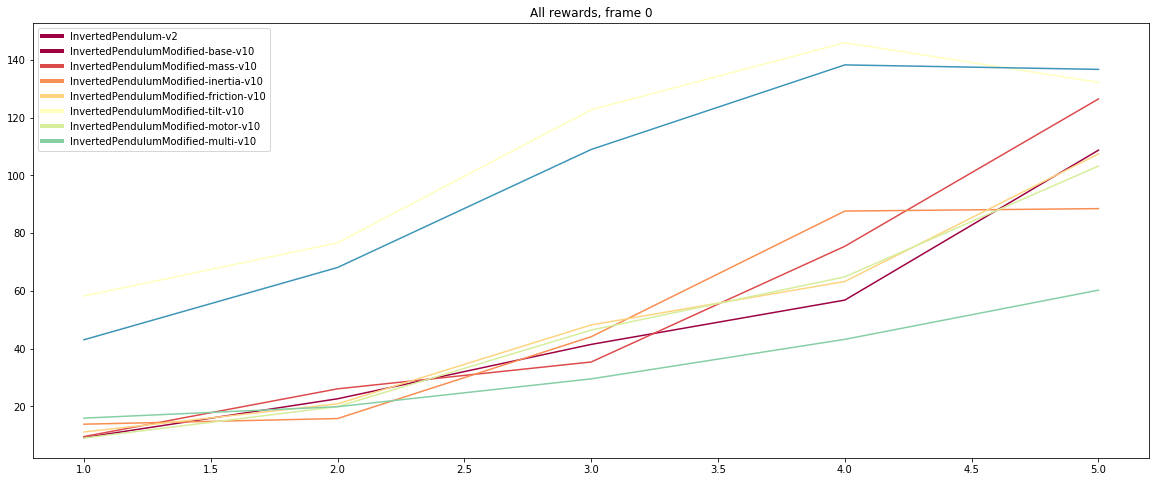

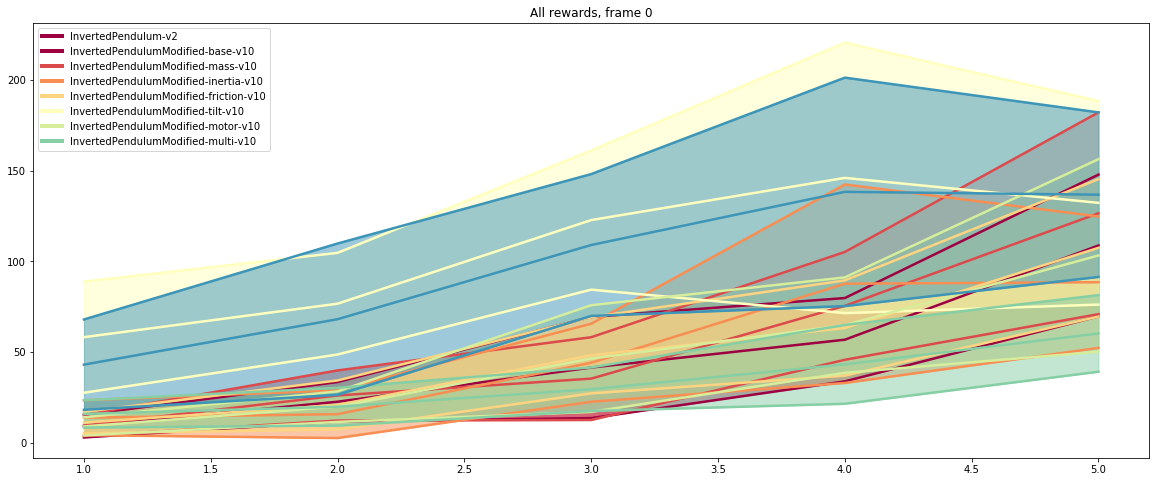

KeyboardInterrupt: 

In [7]:
state = envs.reset()
early_stop = False

while ppo_baseline.frame_idx < max_frames and not early_stop:

    #collect data
    log_probs, values, states, actions, rewards, masks, next_value = ppo_baseline.collect_data(envs)
    
    #compute gae
    returns = ppo_baseline.compute_gae(next_value, rewards, masks, values)
    
    #update policy
    ppo_baseline.ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, values)
    
    #plot
    avg_rew = []
    std = []

    for env in tests.envs:
        env_rewards = ([tests.test_env(env, ppo_baseline.model, ppo_compensator.model) for _ in range(test_itrs)])
        avg_rew.append(np.mean(env_rewards))
        std.append(np.std(env_rewards))

    test_avg_rewards.append(avg_rew)
    test_stds.append(std)


    if avg_rew[0] > threshold_reward and EARLY_STOPPING: #avg_rew[0] is testing on the non edited environment
        tests.plot(frame_idx, test_avg_rewards, test_stds, stdplots, rewplots, indvplots, 1)
        early_stop = True
    else:
        tests.plot(frame_idx, test_avg_rewards, test_stds, stdplots, rewplots, indvplots)

ppo_baseline.save_weights(baseline_dir + 'env_name')